### Imports & Utils

In [0]:
!pip install --upgrade -q https://storage.googleapis.com/jax-wheels/cuda$(echo $CUDA_VERSION | sed -e 's/\.//' -e 's/\..*//')/jaxlib-0.1.12-cp36-none-linux_x86_64.whl
!pip install --upgrade -q jax
!pip install -q git+https://www.github.com/google/jax-md

In [0]:
import numpy as onp

import jax.numpy as np
from jax import random
from jax import jit
key = random.PRNGKey(0)


from colabtools.interactive_widgets import ProgressIter

from jax_md import space, smap, energy, minimize, quantity, simulate

In [0]:
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
import seaborn as sns
  
sns.set_style(style='white')

background_color = [0.85, 0.85, 0.9]

def format_plot(x, y):  
  plt.gca().set_axis_bgcolor(background_color)
  plt.grid(True)
  plt.xlabel(x, fontsize=20)
  plt.ylabel(y, fontsize=20)
  
def finalize_plot(shape=(1, 1)):
  plt.gcf().set_size_inches(
    shape[0] * 1.5 * plt.gcf().get_size_inches()[1], 
    shape[1] * 1.5 * plt.gcf().get_size_inches()[1])
  plt.tight_layout()

# Constant Energy Simulation


Here we demonstrate some code to run a simulation at constant energy. We start off by setting up some parameters of the simulation.

In [0]:
N = 5000
dimension = 2
box_size = 80.0
displacement, shift = space.periodic(box_size) 

Next we need to generate some random positions as well as particle sizes.

In [0]:
key, split = random.split(key)
R = random.uniform(
    split, (N, dimension), minval=0.0, maxval=box_size, dtype=np.float64)

# The system ought to be a 50:50 mixture of two types of particles, one
# large and one small.
sigma = np.array([[1.0, 1.2], [1.2, 1.4]])
N_2 = int(N / 2)
species = np.where(np.arange(N) < N_2, 0, 1)

Then we need to construct our simulation operators.

In [0]:
energy_fn = energy.soft_sphere_pairwise(
    displacement, species=species, sigma=sigma)
init, apply = simulate.nve(energy_fn, shift, 1e-2)
apply = jit(apply)
state = init(key, R, velocity_scale=0.0)

Now let's actually do the simulation. We'll keep track of potential energy and kinetic energy as the simulation progresses.

In [0]:
PE = []
KE = []
for i in ProgressIter(range(200)):
  state = lax.fori_loop(0, 10, lambda _, state: apply(state), state)
  
  PE += [energy_fn(state.position)]
  KE += [quantity.kinetic_energy(state.velocity)]
PE = np.array(PE)
KE = np.array(KE)
R = state.position

Now, let's plot the energy as a function of time. We see that the initial potential energy goes down, the kinetic energy goes up, but the total energy stays constant.

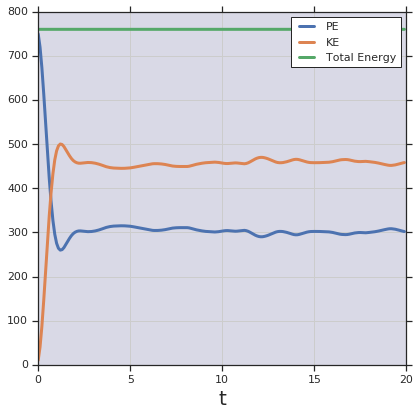

In [0]:
t = onp.arange(0, 2000, 10) * 1e-2
plt.plot(t, PE, label='PE', linewidth=3)
plt.plot(t, KE, label='KE', linewidth=3)
plt.plot(t, PE + KE, label='Total Energy', linewidth=3)
plt.legend()
format_plot('t', '')
finalize_plot()

Now let's plot the system.

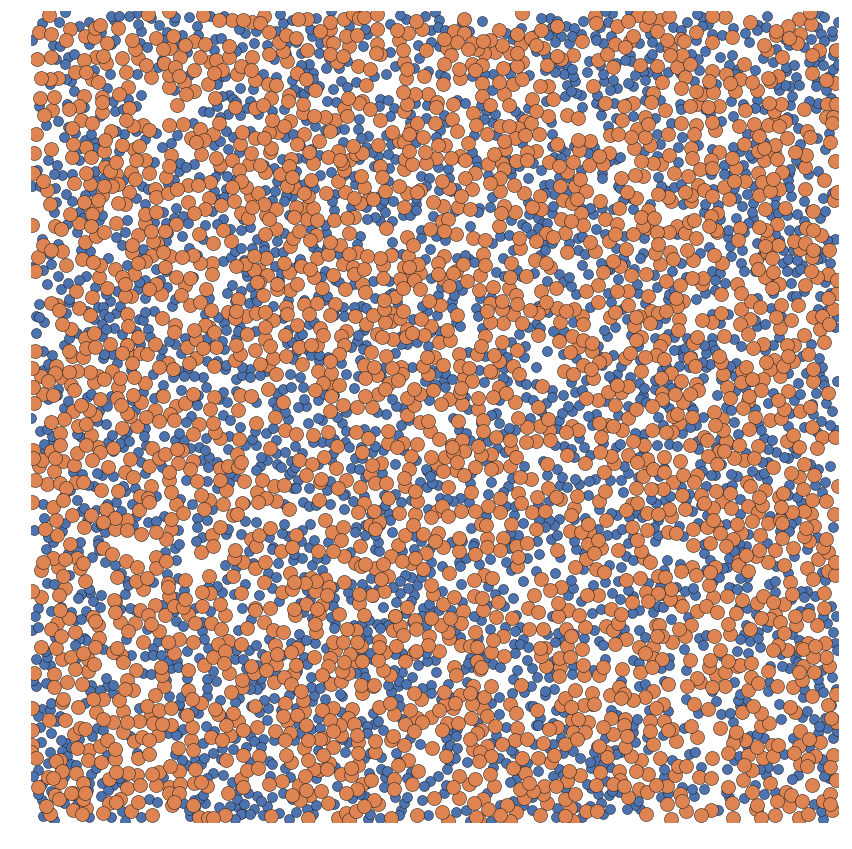

In [0]:
ms = 20
R_plt = onp.array(state.position)

plt.plot(R_plt[:N_2, 0], R_plt[:N_2, 1], 'o', markersize=ms * 0.5)
plt.plot(R_plt[N_2:, 0], R_plt[N_2:, 1], 'o', markersize=ms * 0.7)

plt.xlim([0, np.max(R[:, 0])])
plt.ylim([0, np.max(R[:, 1])])

plt.axis('off')

finalize_plot((2, 2))